#**Import Library & Dataset**

In [10]:
import os
import shutil
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as plt_image
plt.style.use('seaborn')
import cv2
#from sklearn.preprocessing import MinMaxScaler
from skimage.feature import hog
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from joblib import dump, load
from PIL import Image  # For saving the GIF
import imageio  # For creating GIFs
import imutils
from PIL import Image as PILImage

C:\Users\Acer\AppData\Local\Temp\ipykernel_18084\1824716765.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [11]:
os.listdir('dataset')      # Just to show what's inside our current dir
                  # Also can do this from side bar in colab

['predict_test', 'test', 'train', 'val']

In [12]:
os.listdir('dataset/train')

['ba',
 'ca',
 'da',
 'dha',
 'ga',
 'ha',
 'ja',
 'ka',
 'la',
 'ma',
 'na',
 'nga',
 'nya',
 'pa',
 'ra',
 'sa',
 'ta',
 'tha',
 'wa',
 'ya']

In [13]:
os.listdir('dataset/test')

['ba',
 'ca',
 'da',
 'dha',
 'ga',
 'ha',
 'ja',
 'ka',
 'la',
 'ma',
 'na',
 'nga',
 'nya',
 'pa',
 'ra',
 'sa',
 'ta',
 'tha',
 'wa',
 'ya']

Inside datasetv2 folder there are 3 sub-folders. Training to train the model and testing to validate the model. And last prediction to testing the model.

#**Visualisasi**

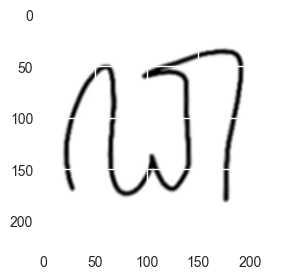

(224, 224, 3)


In [14]:
preview = plt_image.imread('dataset/train/dha/dha_original_dha11.meki.b.png_14a0c118-2b03-46ff-88c2-88f1741ac55a.png')
plt.figure(figsize=(3, 3))
plt.imshow(preview)
plt.show()
print(preview.shape)

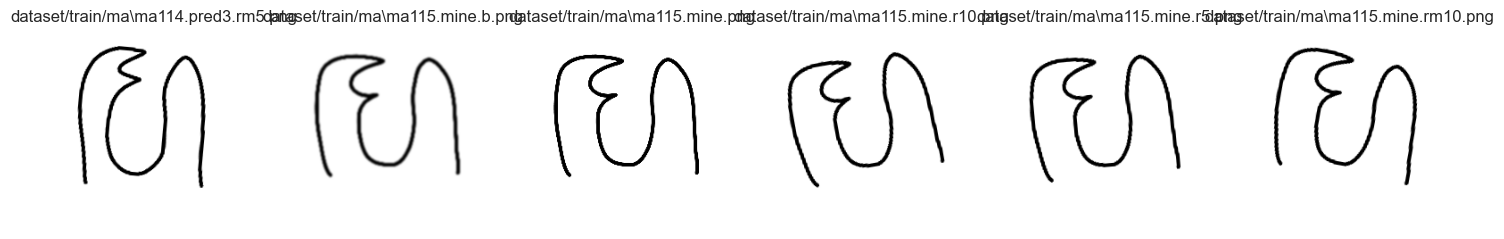

In [15]:
TOTAL = 6                                                  # Total of preview images
index = np.random.randint(20)                              # To randomize the index photo

plt.figure(figsize=(3*TOTAL, 9))

list_ma = [os.path.join('dataset/train/ma', name) for name in os.listdir('dataset/train/ma')[index:index+TOTAL]]

for i, path in enumerate(list_ma):
  plt.subplot(2, TOTAL, i+1)
  plt.axis('off')

  plt.title(path.replace('/content/mix/dataset/visual', ''))
  img = plt_image.imread(path)
  plt.imshow(img)

#**Pre-processing**

In [16]:
def preprocess_image(image):
    # Resize image to 64 x 64
    image = cv2.resize(image, (64, 64))

    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Thresholding
    _, thresh_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Normalisasi manual menggunakan Min-Max Scaling
    scaled_image = thresh_image / 255.0

    return scaled_image

In [17]:
# Load dataset and preprocess images
def load_dataset(data_dir):
    labels = []
    images = []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            for filename in os.listdir(label_dir):
                image_path = os.path.join(label_dir, filename)
                if os.path.isfile(image_path):
                    image = cv2.imread(image_path)
                    if image is not None:
                        preprocessed_image = preprocess_image(image)
                        images.append(preprocessed_image)
                        labels.append(label)
    return np.array(images), np.array(labels)

In [ ]:
# Load training and testing datasets
train_images, train_labels = load_dataset('dataset/train')
test_images, test_labels = load_dataset('dataset/test')

In [12]:
# Print number of unique labels in training and testing datasets
unique_train_labels = np.unique(train_labels)
unique_test_labels = np.unique(test_labels)

print(f'Number of unique classes in training set: {len(unique_train_labels)}')
print(f'Unique classes in training set: {unique_train_labels}')
print(f'Number of unique classes in testing set: {len(unique_test_labels)}')
print(f'Unique classes in testing set: {unique_test_labels}')

Number of unique classes in training set: 20
Unique classes in training set: ['ba' 'ca' 'da' 'dha' 'ga' 'ha' 'ja' 'ka' 'la' 'ma' 'na' 'nga' 'nya' 'pa'
 'ra' 'sa' 'ta' 'tha' 'wa' 'ya']
Number of unique classes in testing set: 20
Unique classes in testing set: ['ba' 'ca' 'da' 'dha' 'ga' 'ha' 'ja' 'ka' 'la' 'ma' 'na' 'nga' 'nya' 'pa'
 'ra' 'sa' 'ta' 'tha' 'wa' 'ya']


In [13]:
# Hitung jumlah data per kelas untuk training
unique_train_labels, train_counts = np.unique(train_labels, return_counts=True)
train_class_distribution = dict(zip(unique_train_labels, train_counts))

print("Jumlah data per kelas dalam dataset training:")
for label, count in train_class_distribution.items():
    print(f'Label {label}: {count} data')

Jumlah data per kelas dalam dataset training:
Label ba: 420 data
Label ca: 420 data
Label da: 420 data
Label dha: 420 data
Label ga: 420 data
Label ha: 420 data
Label ja: 420 data
Label ka: 420 data
Label la: 420 data
Label ma: 420 data
Label na: 420 data
Label nga: 420 data
Label nya: 420 data
Label pa: 420 data
Label ra: 420 data
Label sa: 420 data
Label ta: 420 data
Label tha: 420 data
Label wa: 420 data
Label ya: 420 data


In [14]:
# Hitung jumlah data per kelas untuk testing
unique_test_labels, test_counts = np.unique(test_labels, return_counts=True)
test_class_distribution = dict(zip(unique_test_labels, test_counts))

print("\nJumlah data per kelas dalam dataset testing:")
for label, count in test_class_distribution.items():
    print(f'Label {label}: {count} data')


Jumlah data per kelas dalam dataset testing:
Label ba: 60 data
Label ca: 60 data
Label da: 60 data
Label dha: 60 data
Label ga: 60 data
Label ha: 60 data
Label ja: 60 data
Label ka: 60 data
Label la: 60 data
Label ma: 60 data
Label na: 60 data
Label nga: 60 data
Label nya: 60 data
Label pa: 60 data
Label ra: 60 data
Label sa: 60 data
Label ta: 60 data
Label tha: 60 data
Label wa: 60 data
Label ya: 60 data


#**Feature Extraction**

In [17]:
# Extract HOG features
def extract_hog_features(images):
    hog_features = []
    for image in images:
        features = hog(image, pixels_per_cell=(8, 8), cells_per_block=(4, 4), block_norm='L2-Hys', feature_vector=True)
        hog_features.append(features)
    return np.array(hog_features)

In [18]:
# Extract HOG features for training and testing datasets
train_hog_features = extract_hog_features(train_images)
test_hog_features = extract_hog_features(test_images)

In [19]:
print(f'Bentuk fitur HOG pelatihan: {train_hog_features.shape}')
print(f'Bentuk fitur HOG pengujian: {test_hog_features.shape}')

Bentuk fitur HOG pelatihan: (8400, 3600)
Bentuk fitur HOG pengujian: (1200, 3600)


In [20]:
# Cek Rentang Nilai HOG
min_value = np.min(train_hog_features)
max_value = np.max(train_hog_features)

print(f"Minimum value of HOG features: {min_value}")
print(f"Maximum value of HOG features: {max_value}")

Minimum value of HOG features: 0.0
Maximum value of HOG features: 0.9999999987499999


Fitur ini siap untuk digunakan langsung dalam proses pelatihan model SVM karena berada dalam rentang 0 hingga 1.

In [21]:
# Encode labels
label_encoder = LabelEncoder()
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_test_labels = label_encoder.transform(test_labels)

#**Modelling**

In [22]:
# Hyperparameter tuning with GridSearchCV (custom parameter bisa menyesuaikan)
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear','rbf']
}

grid_search = GridSearchCV(svm.SVC(probability=True), param_grid, refit=True, verbose=3)
grid_search.fit(train_hog_features, encoded_train_labels)

# Print best parameters found by GridSearchCV
print(f'Best parameters found: {grid_search.best_params_}')

# Simpan seluruh hasil pengujian ke dalam file CSV
# Atribut cv_results_ menyimpan seluruh informasi hasil GridSearch
results_df = pd.DataFrame(grid_search.cv_results_)

# Simpan DataFrame ke file CSV
results_df.to_csv('grid_search_results.csv', index=False)

print("Seluruh hasil pengujian berhasil disimpan dalam 'grid_search_results.csv'")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.988 total time=  39.6s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.989 total time=  37.9s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.988 total time=  39.7s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.989 total time=  42.3s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.971 total time=  36.8s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.912 total time= 2.2min
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.904 total time= 2.2min
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.891 total time= 2.2min
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.907 total time= 2.1min
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.878 total time= 2.2min
[CV 1/5] END ..C=0.1, gamma=auto, kernel=linear;, score=0.988 total time=  38.9s
[CV 2/5] END ..C=0.1, gamma=auto, kernel=linear;

In [23]:
# Save the best classifier and label encoder
best_svm_classifier = grid_search.best_estimator_
dump(best_svm_classifier, 'svm_classifier.joblib')
dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']

#**Evaluation**

In [24]:
# Evaluate the classifier
y_pred = best_svm_classifier.predict(test_hog_features)
accuracy = accuracy_score(encoded_test_labels, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 85.75%


In [25]:
print(f'Unique labels in y_true: {np.unique(encoded_test_labels)}')
print(f'Unique labels in y_pred: {np.unique(y_pred)}')
print(f'Label encoder classes: {label_encoder.classes_}')

Unique labels in y_true: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Unique labels in y_pred: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label encoder classes: ['ba' 'ca' 'da' 'dha' 'ga' 'ha' 'ja' 'ka' 'la' 'ma' 'na' 'nga' 'nya' 'pa'
 'ra' 'sa' 'ta' 'tha' 'wa' 'ya']


<Figure size 1600x1400 with 0 Axes>

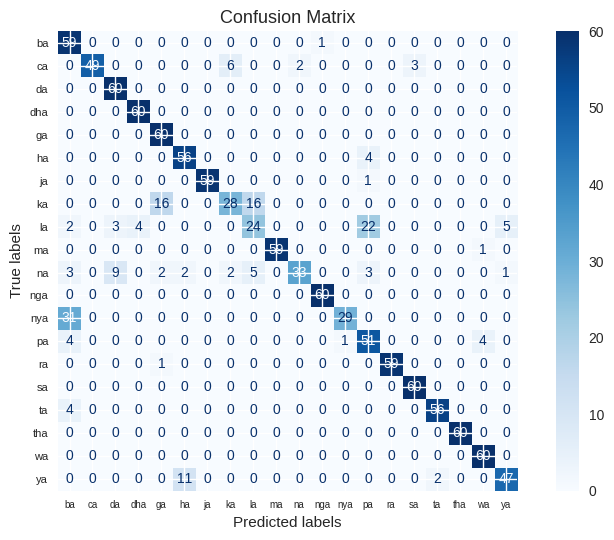

In [26]:
# Compute and display the confusion matrix
unique_labels = np.unique(encoded_test_labels)
conf_matrix = confusion_matrix(encoded_test_labels, y_pred, labels=unique_labels)

# Mengatur ukuran figure
plt.figure(figsize=(16,14))  # Sesuaikan lebar dan tinggi sesuai kebutuhan

# Visualisasi confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.inverse_transform(unique_labels))
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Mengatur rotasi dan ukuran font label
plt.xticks(fontsize=7)  # Rotasi dan penyesuaian font untuk label sumbu x
plt.yticks(fontsize=8)  # Penyesuaian font untuk label sumbu y

# Menambahkan label sumbu dan judul jika diperlukan
plt.xlabel('Predicted labels', fontsize=11)
plt.ylabel('True labels', fontsize=11)
plt.title('Confusion Matrix', fontsize=13)

plt.tight_layout()  # Mengatur tata letak agar label tidak terpotong
plt.show()

In [27]:
# Menghitung prediksi
y_pred = best_svm_classifier.predict(test_hog_features)

# Menghitung precision, recall, dan F1-score
precision = precision_score(encoded_test_labels, y_pred, average='weighted')
recall = recall_score(encoded_test_labels, y_pred, average='weighted')
f1 = f1_score(encoded_test_labels, y_pred, average='weighted')

# Mencetak metrik
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

# Mencetak classification report
report = classification_report(encoded_test_labels, y_pred, target_names=label_encoder.classes_)
print('Classification Report:')
print(report)

Precision: 87.38%
Recall: 85.75%
F1 Score: 85.09%
Classification Report:
              precision    recall  f1-score   support

          ba       0.57      0.98      0.72        60
          ca       1.00      0.82      0.90        60
          da       0.83      1.00      0.91        60
         dha       0.94      1.00      0.97        60
          ga       0.76      1.00      0.86        60
          ha       0.81      0.93      0.87        60
          ja       1.00      0.98      0.99        60
          ka       0.78      0.47      0.58        60
          la       0.53      0.40      0.46        60
          ma       1.00      0.98      0.99        60
          na       0.94      0.55      0.69        60
         nga       0.98      1.00      0.99        60
         nya       0.97      0.48      0.64        60
          pa       0.63      0.85      0.72        60
          ra       1.00      0.98      0.99        60
          sa       0.95      1.00      0.98        60
        

#**Prediction**

In [7]:
# Load the classifier and label encoder
best_svm_classifier = load('svm_classifier.joblib')
label_encoder = load('label_encoder.joblib')

c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator SVC from version 1.3.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.3.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Sebelum membuat prediksi, gambar input harus melalui proses preprocessing yang sama seperti yang digunakan saat training model. Ini termasuk resizing, thresholding, Min-Max scaling, dan ekstraksi fitur menggunakan HOG.

In [48]:
# Fungsi untuk mengurutkan kontur (kiri ke kanan atau atas ke bawah)
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return (cnts, boundingBoxes)

# Fungsi untuk praproses gambar
def preprocess_image(image):
    image = cv2.resize(image, (64, 64))  # Resize image to 64 x 64
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)  # Gaussian Blur to reduce noise
    _, thresh_image = cv2.threshold(blurred_image, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)  # Thresholding
    scaled_image = thresh_image / 255.0  # Normalize using Min-Max Scaling
    return scaled_image

# Fungsi untuk ekstraksi fitur HOG
def extract_hog_features(image):
    features,hog_image = hog(image, pixels_per_cell=(8, 8), cells_per_block=(4, 4), block_norm='L2-Hys', feature_vector=True,visualize=True)
    return features,hog_image

# Fungsi untuk menghitung ukuran fitur HOG yang diharapkan
def calculate_expected_hog_feature_size(image_size, pixels_per_cell, cells_per_block, orientations):
    n_cells = (image_size[0] // pixels_per_cell[0], image_size[1] // pixels_per_cell[1])
    block_size = cells_per_block[0] * cells_per_block[1] * orientations
    n_blocks = (n_cells[0] - cells_per_block[0] + 1, n_cells[1] - cells_per_block[1] + 1)
    return n_blocks[0] * n_blocks[1] * block_size

# Fungsi untuk memprediksi satu karakter
def recognize_single_character(image, expected_feature_size):
    preprocessed_image = preprocess_image(image)  # Preprocessing gambar
    hog_features,hog_image = extract_hog_features(preprocessed_image)  # Ekstraksi fitur HOG

    if hog_features.size != expected_feature_size:  # Pastikan dimensi fitur sesuai dengan model
        raise ValueError(f'Ketidakcocokan ukuran fitur: Diharapkan {expected_feature_size}, tetapi didapat {hog_features.size}')

    hog_features = hog_features.reshape(1, -1)  # Reshape untuk model SVM
    prediction = best_svm_classifier.predict(hog_features)  # Prediksi karakter menggunakan model SVM
    character = label_encoder.inverse_transform(prediction)  # Transformasikan prediksi ke label aslinya
    return character[0], preprocessed_image,hog_image

# Fungsi untuk mendapatkan karakter dari bounding box
def get_letters(img):
    letters = []
    frames = []  # Store frames for GIF creation

    # Konversi gambar ke skala abu-abu dan binarisasi
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # Apply Gaussian Blurring
    ret, thresh1 = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY_INV)

    # Increase dilation to close gaps within characters
    kernel = np.ones((5,5), np.uint8)  # Larger kernel
    dilated = cv2.dilate(thresh1, kernel, iterations=2)

    # mendapatkan contours
    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    i=0
    # Loop melalui kontur dan ekstrak karakter
    for c in cnts:
        if cv2.contourArea(c) > 10:
            i=i+1
            (x, y, w, h) = cv2.boundingRect(c)
            roi = image[y:y + h, x:x + w]  # Ambil gambar di dalam bounding box

            # Tambahkan padding untuk meningkatkan prediksi
            bordersize = int(0.1 * x)
            roi = cv2.copyMakeBorder(
                roi,
                top=bordersize,
                bottom=bordersize,
                left=bordersize,
                right=bordersize,
                borderType=cv2.BORDER_CONSTANT,
                value=[255, 255, 255]
            )

            # Resize dan praproses karakter
            resized = cv2.resize(roi, (64, 64))
            preprocessed_image = preprocess_image(resized)

            # Ekstraksi fitur HOG dan prediksi karakter
            expected_feature_size = calculate_expected_hog_feature_size((64, 64), (8, 8), (4, 4), 9)
            predicted_character,preprocessed_image,hog_image = recognize_single_character(resized, expected_feature_size)

            # Konversi gambar dari skala abu-abu ke RGB untuk tampilan
            preprocessed_image_rgb = (preprocessed_image * 255).astype(np.uint8)
            preprocessed_image_rgb = cv2.cvtColor(preprocessed_image_rgb, cv2.COLOR_GRAY2RGB)

            # Tampilkan gambar dan hasil deteksi dalam tampilan menyamping
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 4, 1)
            plt.imshow(resized)  # Tampilkan gambar asli
            plt.title(f'bounding box ke- {i}')
            plt.axis('off')

            plt.subplot(1, 4, 2)
            plt.imshow(preprocessed_image_rgb)  # Tampilkan gambar asli
            plt.title(f'preprocessing')
            plt.axis('off')

            plt.subplot(1, 4, 3)
            plt.imshow(hog_image)
            plt.title(f'HOG')
            plt.axis('off')

            plt.subplot(1, 4, 4)
            plt.imshow(preprocessed_image)
            plt.title(f'Hasil Deteksi: {predicted_character}')
            plt.axis('off')

            # Simpan gambar sebagai file PNG
            plt.savefig(f'output/proses/{"".join(predicted_character)}_bounding_box_{i}.png', bbox_inches='tight')

            plt.show()

            # Simpan prediksi karakter
            letters.append(predicted_character)

            # Gambarkan bounding box dan label
            cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
            cv2.putText(image, predicted_character, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
          
            # Convert image for GIF
            frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for PIL
            frames.append(PILImage.fromarray(frame))
    gif_filename = f'output/gif/{"".join(letters)}.gif'
    # Buat GIF dari semua frame yang ditangkap
    frames[0].save(gif_filename, save_all=True, append_images=frames[1:], duration=500, loop=0)

    return letters, image

# Fungsi untuk memproses gambar dan menampilkan hasil
def recognize_and_display_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f'Error: Gambar tidak ditemukan di {image_path}')
        return

    try:
        letters, image_with_boxes = get_letters(image_path)

        # Tampilkan gambar dan hasil deteksi dalam tampilan menyamping
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Tampilkan gambar asli
        plt.title(f'Asli: {os.path.basename(image_path)}')
        plt.axis('off')

        # Tampilkan gambar dengan kotak dan prediksi
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
        plt.title(f'Hasil Deteksi: {"".join(letters)}')
        plt.axis('off')
        plt.show()

    except ValueError as e:
        print(f'Error processing {image_path}: {e}')

# Fungsi utama untuk memproses gambar dan menampilkan prediksi
def main(image_path=None,folder_path=None):
    if image_path:
        recognize_and_display_image(image_path)
    elif folder_path:
        for filename in os.listdir(folder_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(folder_path, filename)
                recognize_and_display_image(image_path)
    else:
        print('Error: Harap tentukan path gambar.')


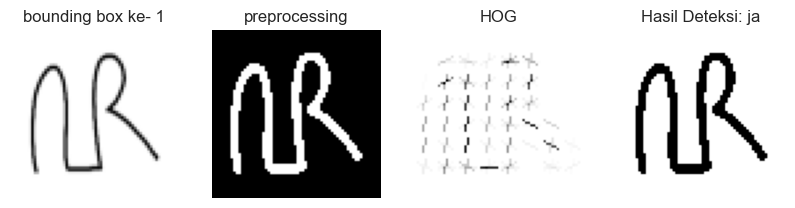

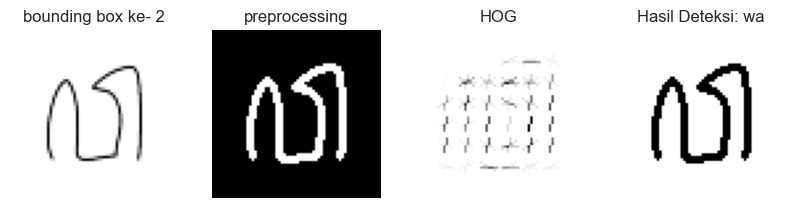

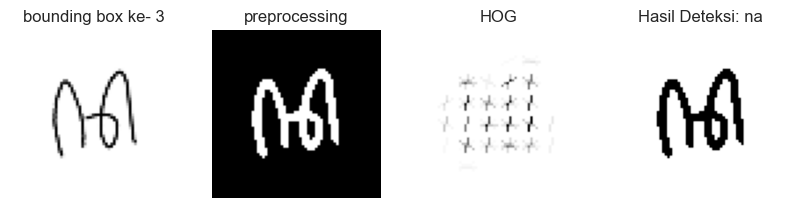

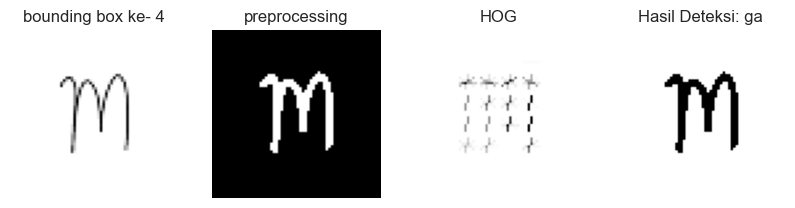

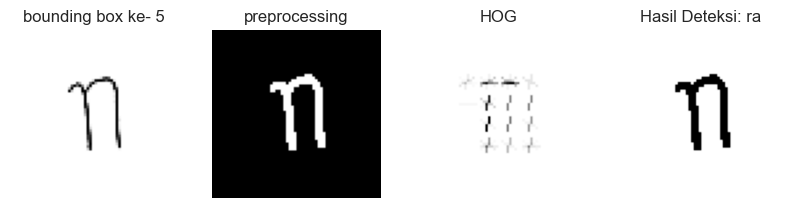

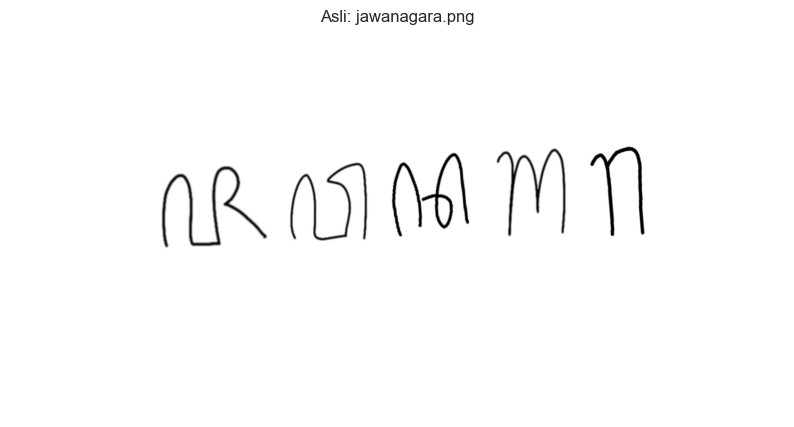

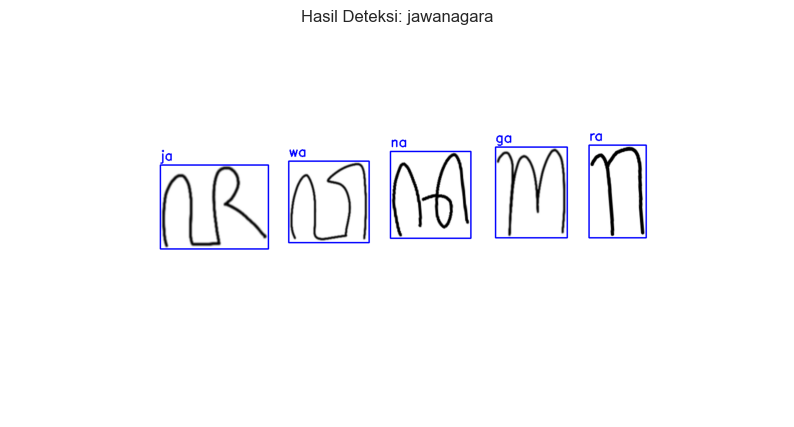

In [15]:
main(image_path='dataset/predict_test/jawanagara.png')

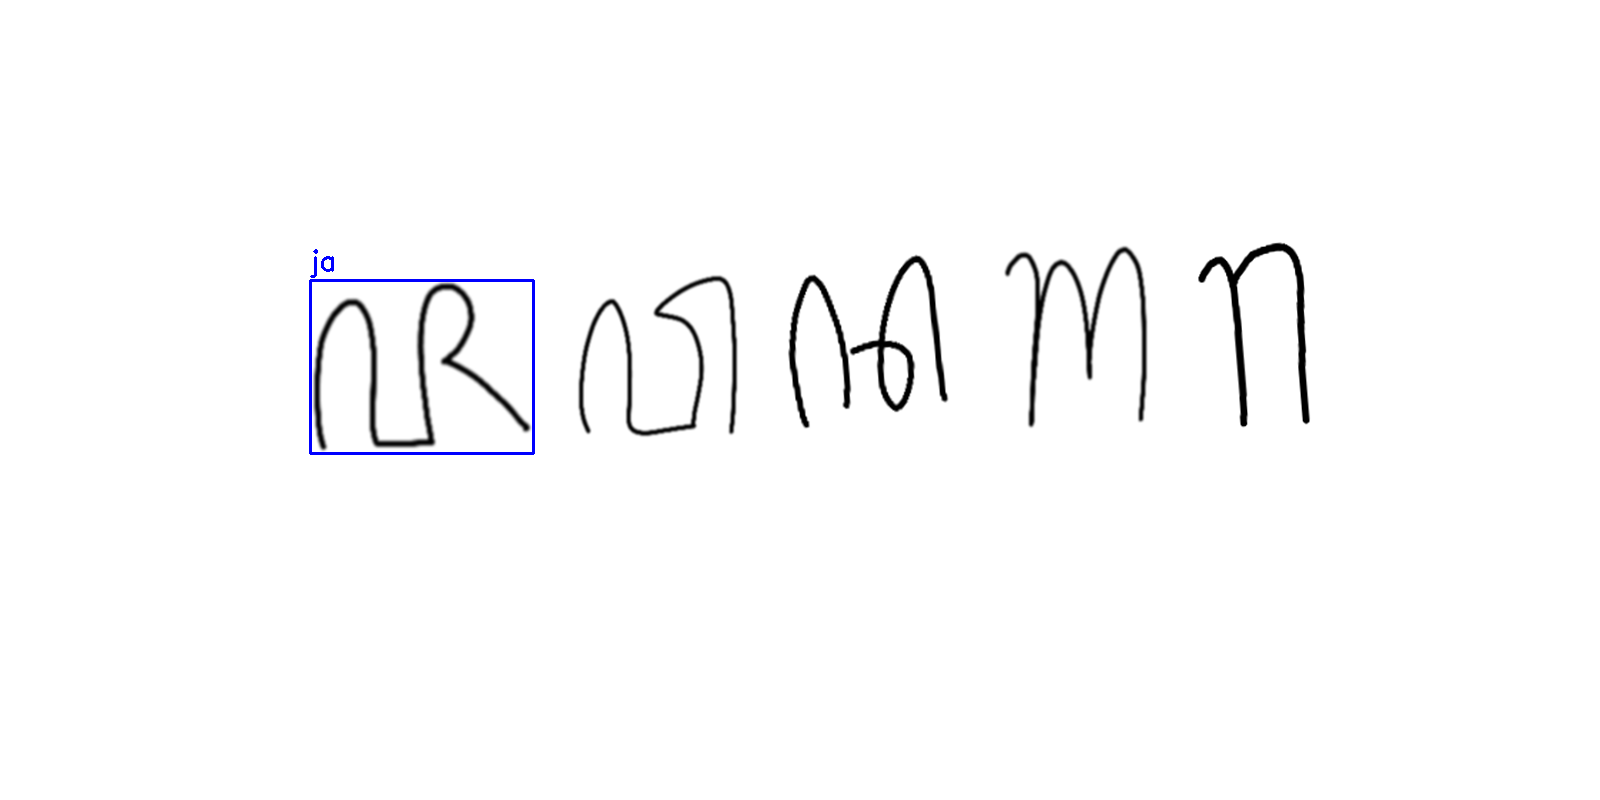

In [16]:
from IPython.display import Image, display

# menampilkan gambar gif
def display_gif(gif_path):
    with open(gif_path, 'rb') as file:
        display(Image(data=file.read(), format='gif'))

# sesuaikan dengan direktori gif
display_gif("output/gif/jawanagara.gif")

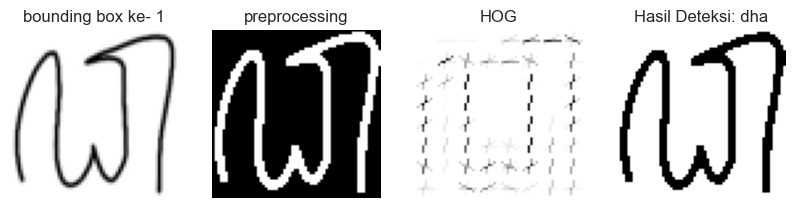

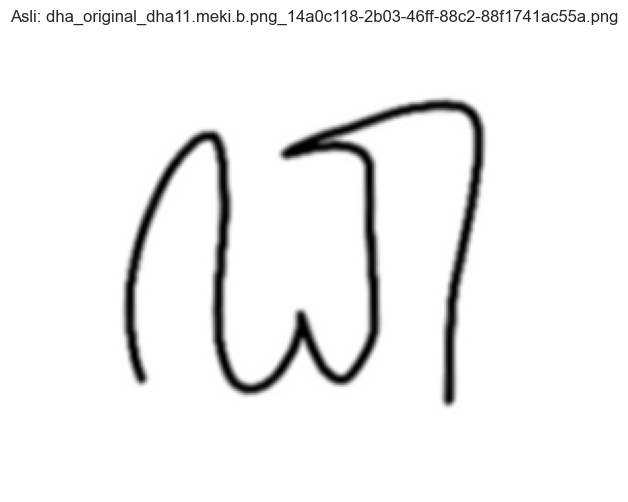

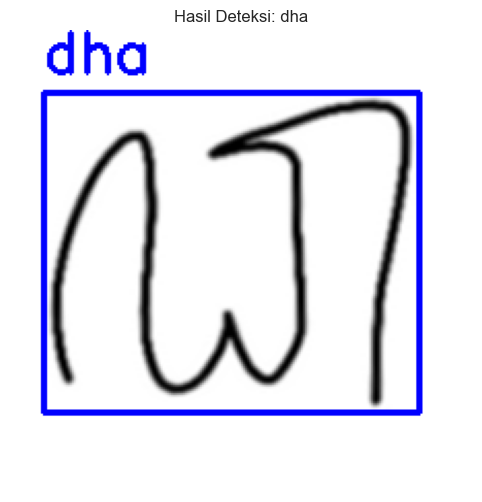

In [17]:
main(image_path='dataset/train/dha/dha_original_dha11.meki.b.png_14a0c118-2b03-46ff-88c2-88f1741ac55a.png')

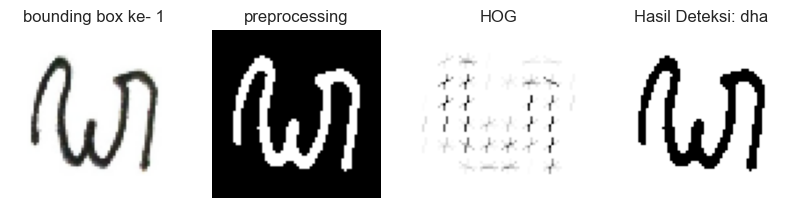

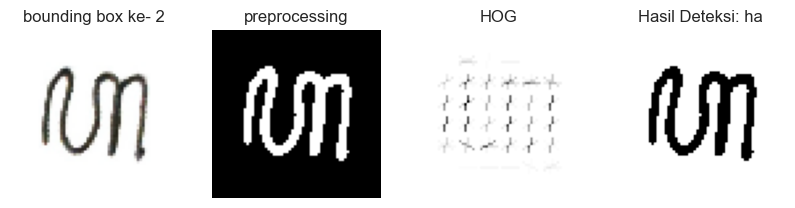

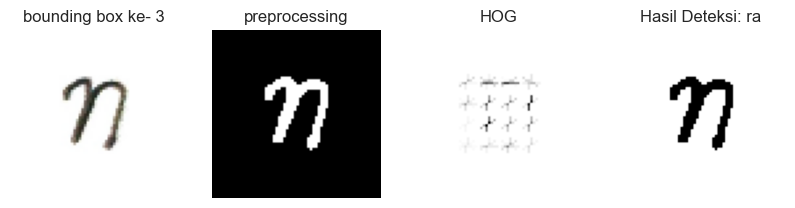

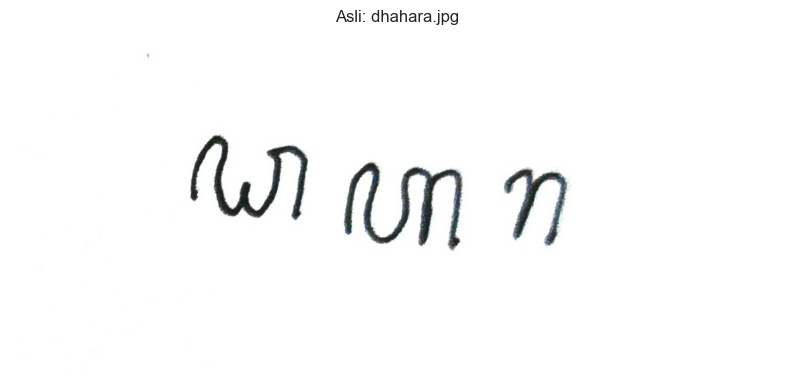

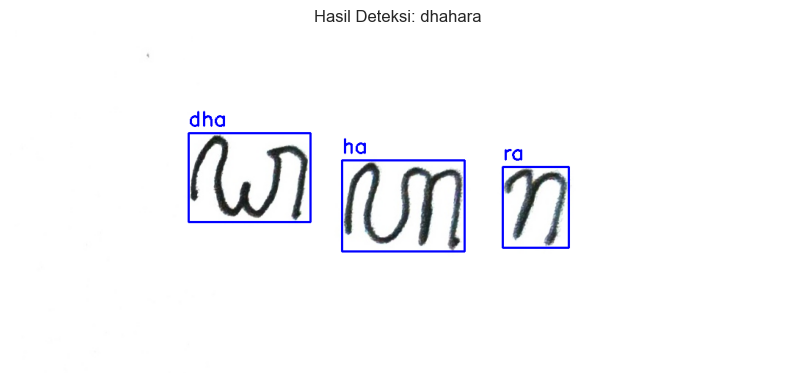

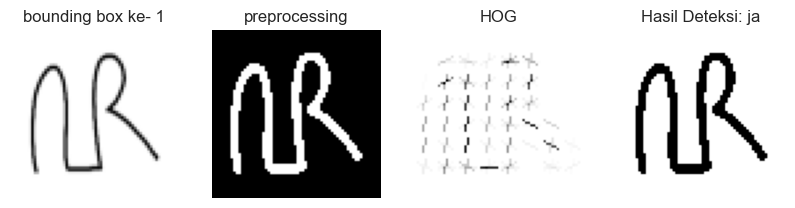

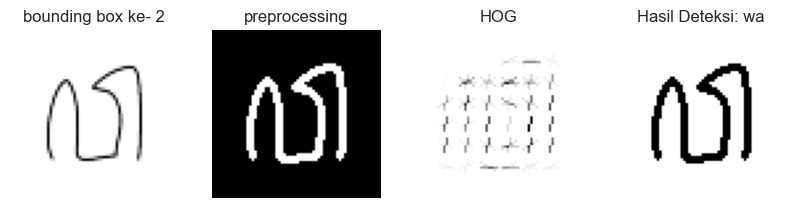

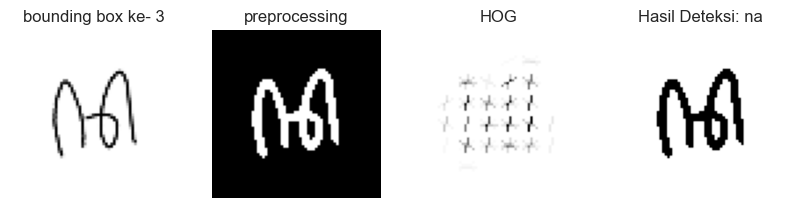

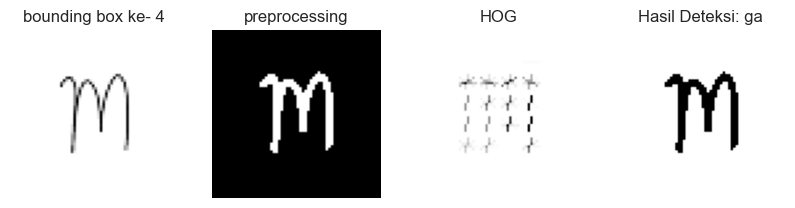

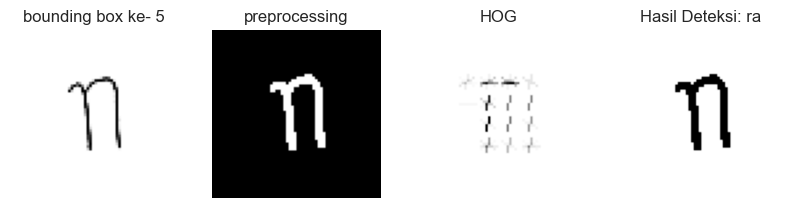

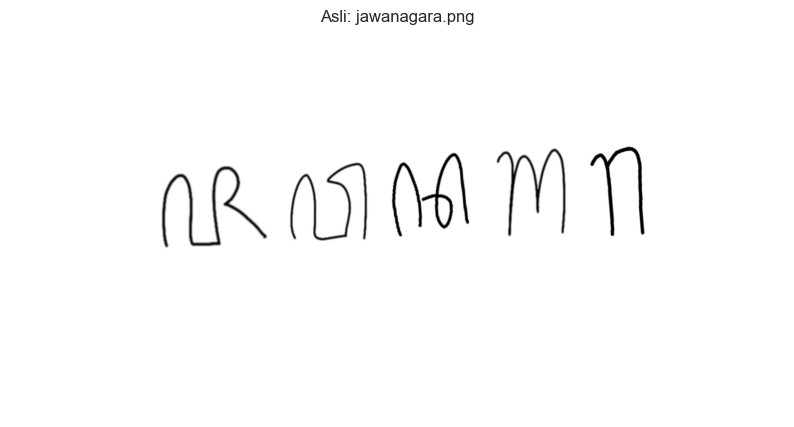

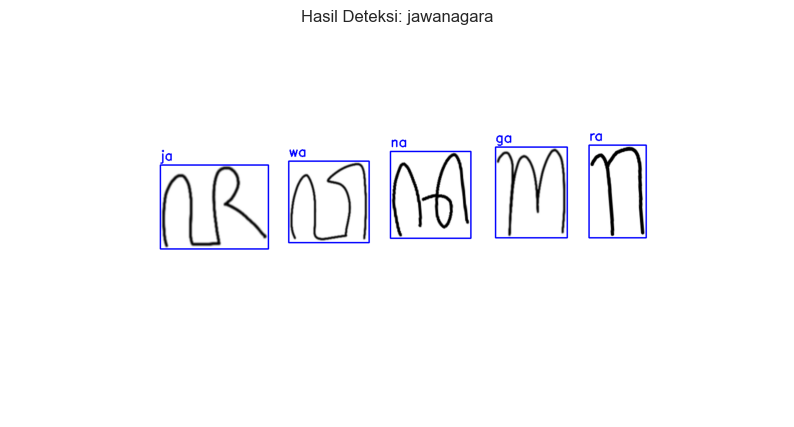

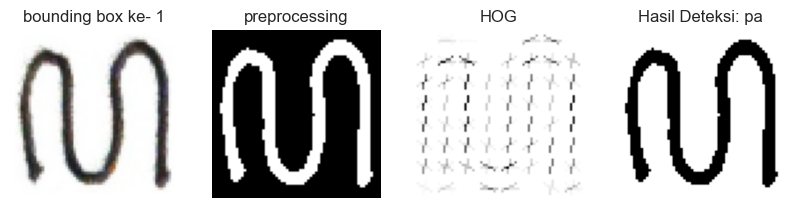

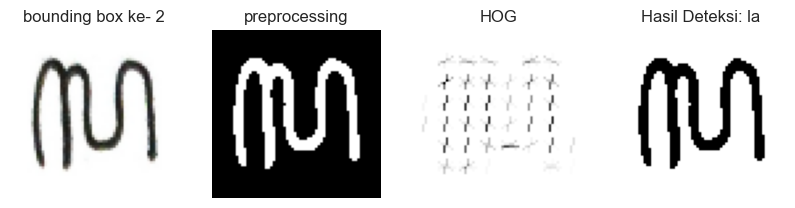

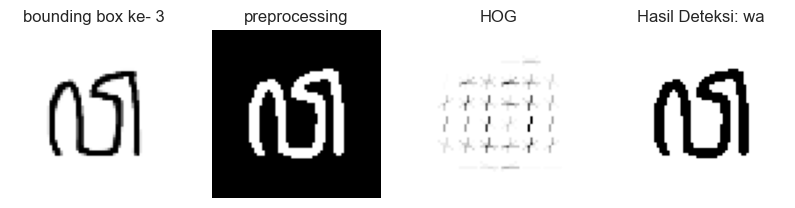

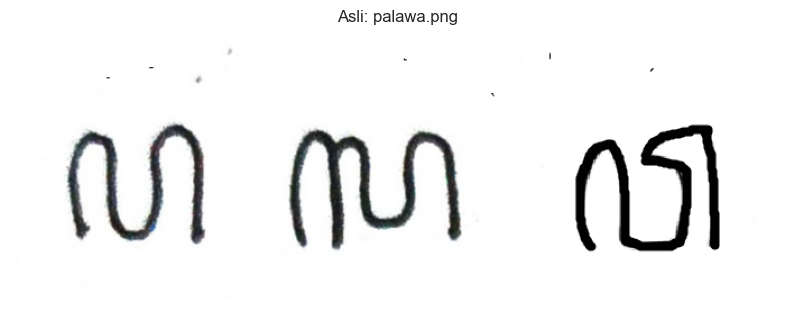

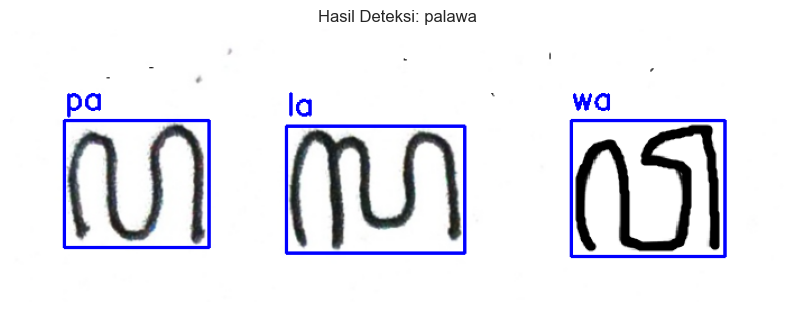

In [18]:
# Memproses semua gambar dalam folder prediction
main(folder_path='dataset/predict_test')

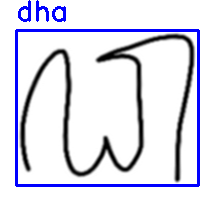

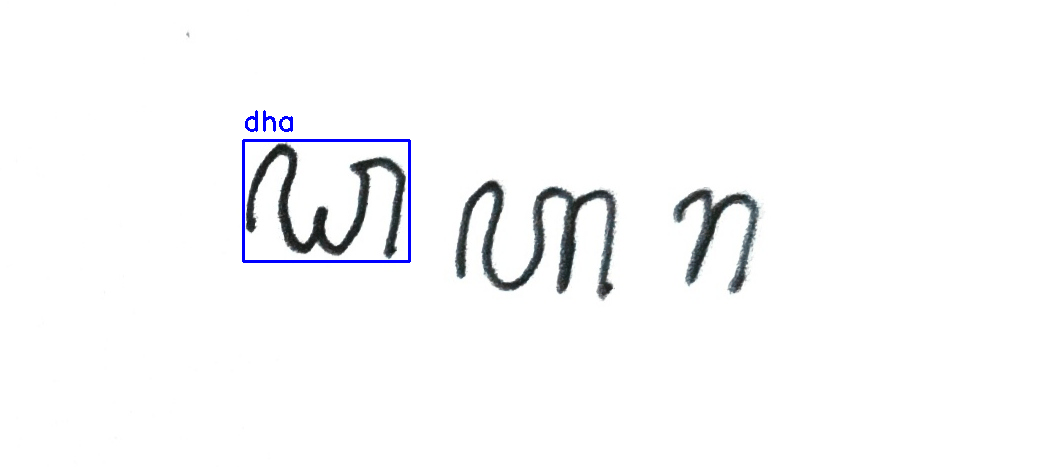

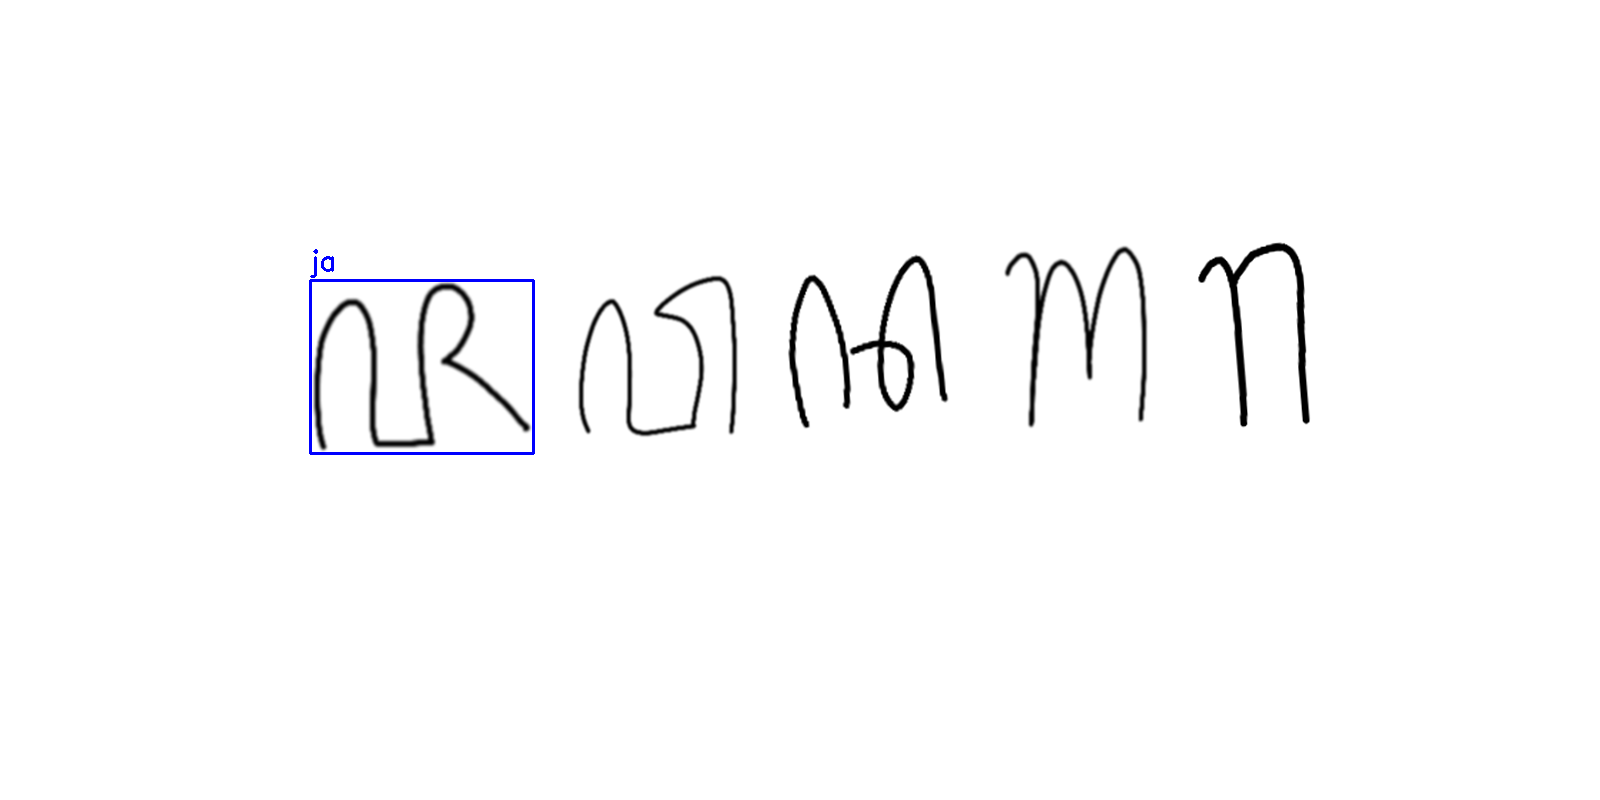

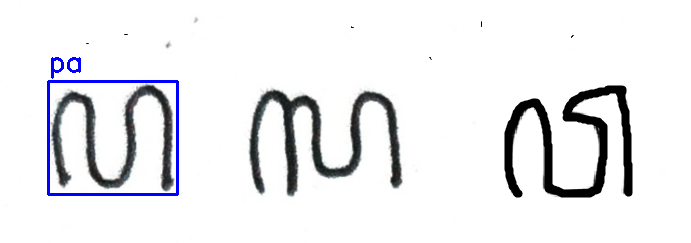

In [21]:

                    
# menampilkan gambar gif
def display_gif_folder(gif_folder_path):
    for filename in os.listdir(gif_folder_path):
        if filename.endswith(('.gif')):
            gif_path = os.path.join(gif_folder_path, filename)
            with open(gif_path, 'rb') as file:
                display(Image(data=file.read(), format='gif'))

# sesuaikan dengan direktori gif
display_gif_folder("output/gif")